In [1]:
%cd /home/vasily/Desktop/research/Model/Rydberg/

/home/vasily/Desktop/research/Model/Rydberg


In [2]:
import numpy as np
import pickle
from time import time
from joblib import Parallel, delayed
import sys
import os
sys.path.append(os.path.abspath('.'))


from src.models.mlp import MLP
from src.eval import RydbergEvaluator
from src.eval.eval_rydberg import est_density_from_z_measurements,determine_phase_1D,est_order_param_1D,phase2img,est_phase_diagram,est_order_param_1D_fourier_from_measurements,est_order_param_1D_fourier,est_order_param_1D_from_measurements
from src.data.loading.dataset_rydberg import RydbergDataset,unif_sample_on_grid


import torch
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from tqdm.notebook import tqdm,trange
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from SVMplus import MulticlassSVMplus
import warnings
warnings.filterwarnings('ignore')

from src.utils import plot_phase_diagram

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:

%cd /home/vasily/Desktop/research/Model/Rydberg/
import os
print(os.getcwd())
os.listdir('src')
# os.listdir('src/models')


/home/vasily/Desktop/research/Model/Rydberg
/home/vasily/Desktop/research/Model/Rydberg


['training',
 'data',
 'models',
 'utils.py',
 '__pycache__',
 '__init__.py',
 'properties',
 'eval']

## Rydberg Data preparation

### H params + Phase

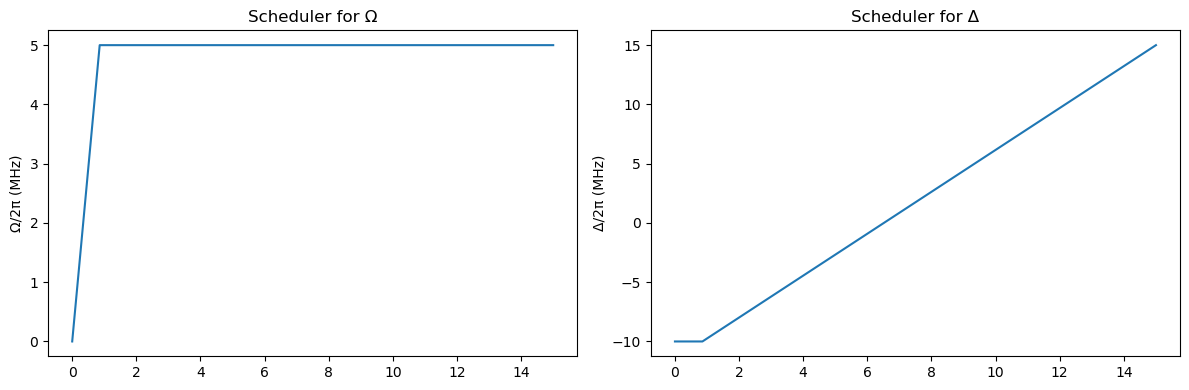

In [4]:

# Here we define a base schedule -- 
base_time = 3.5
ts = np.array([0,0.2,base_time])
omegas = np.array([0, 5, 5])
deltas = np.array([-10, -10, 15])
total_time = 15 # Total adiabatic evolution time of the Bloqade simulation
# We propotionally lengthen the schedules for Omega and Delta by time_ratio = total_time/base_time
time_ratio = total_time/base_time


fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
ax1.plot(ts*time_ratio, omegas)
ax1.set_ylabel("Ω/2π (MHz)")
ax1.set_title("Scheduler for Ω")
ax2.plot(ts*time_ratio, deltas)
ax2.set_ylabel("Δ/2π (MHz)")
ax2.set_title("Scheduler for Δ")
fig.tight_layout()

In [5]:
n_qubits = 31 # number of Rydberg atoms in the 1D lattice

dim=1 # dimension of the system
ny = 1 # since we are working in 1D, this variable is fixed to 1
nx = n_qubits # effectively, we are working on a 2D lattice of dimensions nx*ny, where nx=n_qubits and ny=1.
z2_threshold=0.7 # threshold for the Z2 order parameter to determine a state is in Z2 phase
z3_threshold = 0.6 # threshold for the Z3 order parameter to determine a state is in Z3 phase

# We load simulation data for the lattice defined above with the adiabatic evolution scheduler preset above.
folder = f'data/1D-Phase_{nx}/1D-Phase_{nx}/{float(np.round(total_time,2))}µs/'
folder

'data/1D-Phase_31/1D-Phase_31/15.0µs/'

In [6]:
# extra variables we want the conditional generative variable to condition on, except for "nx", "ny", "interaction_range".
# detuning = Delta/Omega
extra_variables = ["detuning",] 
meta_dataset = RydbergDataset(dim=dim,nx = nx, ny=ny, folder=folder,n_threads=1, var_name='interaction_range',variables = extra_variables) 

In [7]:
meta_dataset.est_order_params()
meta_dataset.info["phase" ] = determine_phase_1D(meta_dataset.info["Z2"], meta_dataset.info["Z3"],z2_threshold=z2_threshold,
                                                z3_threshold=z3_threshold
                                            )

In [8]:
# The function is related to the plotting of the diagram
# Use without loading pretrained data
# unif_sample_on_grid creates a representative sample by dividing a 2D parameter space into a grid and 
# randomly selecting one data point from each occupied grid cell

def prepare_train_set(meta_dataset, df=None, n_measurements:int = -1, x_bins=10,y_bins=10):
    train_set = {}
    if df is None: df = meta_dataset.info
    train_idxes, train_df = unif_sample_on_grid(df.copy(),x_bins=x_bins,y_bins=y_bins)
    # train_idxes = plot_df.index.values
    train_keys = meta_dataset.keys[train_idxes]
    train_set.update(meta_dataset.prepare_train_set(train_keys,n_measurements=n_measurements))
    return train_set, train_idxes

In [9]:
load_pretrained = False

if load_pretrained:
    # If loading a pretrained model, we need to also load the training set that 
    # it was trained on (specified by sampled indices of the meta_dataset.info DataFrame)
    train_idxes = np.load('logs/rydberg_1D/train_idxes.npy')
    train_set = pickle.load(open('logs/rydberg_1D/train_set.pkl','rb'))
else:
    # If train from scratch, we sample training data from the phase diagram specified by plot_df
    train_set, train_idxes = prepare_train_set(meta_dataset)
    ## If you want to save this training set, you can un-comment the following lines:
    # np.save('logs/rydberg_1D/train_idxes.npy',train_idxes)
    # pickle.dump(train_set, open('logs/rydberg_1D/train_set.pkl','wb'))
    # pickle.dump(meta_dataset, open('logs/rydberg_1D/meta_dataset.pkl','wb'))

In [10]:
all_idxes = set(meta_dataset.info.index)
# Get training indexes as a set
train_idxes_set = set(train_idxes)
# Find the rest (test/unused) indexes
rest_idxes = list(all_idxes - train_idxes_set)

data_train = meta_dataset.info.copy().loc[list(train_idxes)]
data_test = meta_dataset.info.copy().loc[rest_idxes]
data_test.describe()


,nx,ny,interaction_range,detuning,Z2,Z3,Z4
count,1460.0,1460.0,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,31.0,1.0,1.997500,0.498858,0.627767,0.450579,0.314106
std,0.0,0.0,0.562385,1.480079,0.162980,0.151973,0.081538
min,31.0,1.0,1.050000,-2.000000,0.486144,0.331168,0.235523
25%,31.0,1.0,1.500000,-0.750000,0.531433,0.374177,0.266709
50%,31.0,1.0,2.000000,0.500000,0.550646,0.383648,0.276758
75%,31.0,1.0,2.500000,1.717949,0.604491,0.444752,0.303566
max,31.0,1.0,2.950000,3.000000,0.984830,0.987812,0.492523


In [11]:
len(train_idxes_set)

100

In [12]:
data_train.tail()

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
76,31.0,1.0,2.10,2.615385,0.546114,0.900719,0.271233,Z3
757,31.0,1.0,2.40,2.743590,0.549913,0.832685,0.274674,Z3
1479,31.0,1.0,2.60,3.000000,0.549120,0.681994,0.274285,Z3
39,31.0,1.0,2.80,3.000000,0.551642,0.505437,0.280865,Disordered
319,31.0,1.0,2.85,3.000000,0.563107,0.455085,0.283733,Disordered


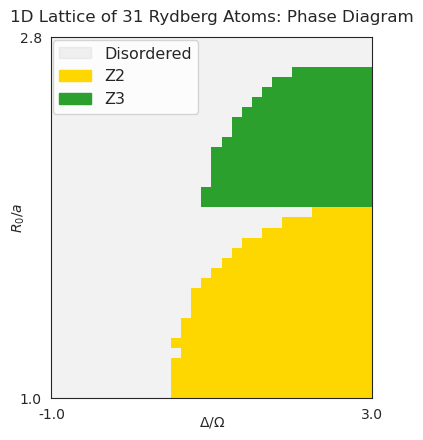

In [13]:
# This diagram has nothing to do with the data_test and data_train we defined above

sns.set_style('white')
hue_order = ['Disordered','Z2','Z3']
plot_df = meta_dataset.info.copy()
plot_df = plot_df.loc[(plot_df['detuning'] >=-1) & (plot_df['interaction_range'] <= 2.8) & (plot_df['interaction_range'] > 1)]
fig = plot_phase_diagram(plot_df,title=f"1D Lattice of {n_qubits} Rydberg Atoms: Phase Diagram",hue_order = hue_order,
                        legend=True)

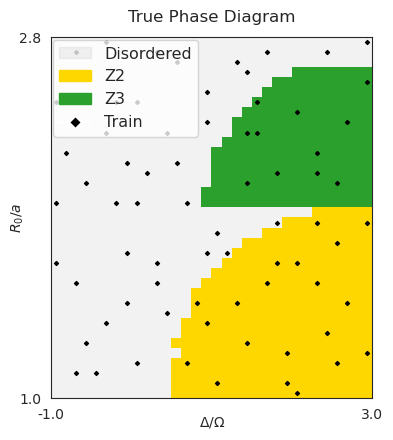

In [14]:
# Filter train_idxes to only those present in plot_df
valid_train_idxes = [idx for idx in train_idxes if idx in plot_df.index]

fig_true = plot_phase_diagram(
    plot_df,
    title="True Phase Diagram",
    train_idxes=valid_train_idxes,
    hue_order=hue_order,
    legend=True
)

### Prepare dataset where points would be closer to the phase boundary

In [15]:
def prepare_weighted_boundary_train_set(meta_dataset, boundary_weight=6.0, n_samples=None, 
                                       z2_threshold=0.7, z3_threshold=0.6, tolerance=0.12):
    """
    Prepare training set with higher probability for boundary points
    
    Args:
        meta_dataset: Your RydbergDataset
        boundary_weight: How much more likely boundary points should be selected (e.g., 3.0 = 3x more likely)
        n_samples: Number of samples to draw (if None, uses same logic as original)
        z2_threshold, z3_threshold, tolerance: Boundary detection parameters
    """
    
    df = meta_dataset.info.copy()
    
    # Identify boundary points
    # boundary_mask = (
    #     (np.abs(df['Z2'] - z2_threshold) <= tolerance) |
    #     (np.abs(df['Z3'] - z3_threshold) <= tolerance) |
    #     ((df['Z2'] < z2_threshold + tolerance) & (df['Z3'] < z3_threshold + tolerance))
    # )
    
    boundary_mask = (
    (np.abs(df['Z2'] - z2_threshold) <= tolerance) |
    (np.abs(df['Z3'] - z3_threshold) <= tolerance) 
    # ((df['Z2'] < z2_threshold + tolerance) & (df['Z3'] < z3_threshold + tolerance))
)

    # Create weights: higher for boundary points
    weights = np.ones(len(df))
    weights[boundary_mask] = boundary_weight
    
    # Normalize weights to probabilities
    probabilities = weights / weights.sum()
    
    # Determine number of samples
    if n_samples is None:
        # Use similar logic to original unif_sample_on_grid
        n_samples = min(len(df), 100)  # Adjust based on your needs
    
    # Sample indices with weighted probabilities
    train_idxes = np.random.choice(
        df.index, 
        size=n_samples, 
        replace=False, 
        p=probabilities
    )
    
    # Prepare training set
    train_keys = meta_dataset.keys[train_idxes]
    train_set = {}
    train_set.update(meta_dataset.prepare_train_set(train_keys, n_measurements=-1))
    
    return train_set, train_idxes

In [16]:
z2_threshold=0.7
z3_threshold=0.6
tolerance=0.12
df = meta_dataset.info.copy()

# Identify boundary points
boundary_mask = (
    (np.abs(df['Z2'] - z2_threshold) <= tolerance) |
    (np.abs(df['Z3'] - z3_threshold) <= tolerance) 
    # ((df['Z2'] < z2_threshold + tolerance) & (df['Z3'] < z3_threshold + tolerance))
)

type(boundary_mask)


pandas.core.series.Series

In [17]:
df.head()

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
0,31.0,1.0,2.8,-2.000000,0.518066,0.339910,0.275933,Disordered
1,31.0,1.0,2.8,-1.871795,0.531916,0.349755,0.263841,Disordered
2,31.0,1.0,2.8,-1.743590,0.524948,0.355736,0.255216,Disordered
3,31.0,1.0,2.8,-1.615385,0.506991,0.355444,0.250079,Disordered
4,31.0,1.0,2.8,-1.487179,0.538352,0.362231,0.265651,Disordered


In [18]:
df.tail(5)

,nx,ny,interaction_range,detuning,Z2,Z3,Z4,phase
1555,31.0,1.0,1.4,2.487179,0.978077,0.373723,0.487513,Z2
1556,31.0,1.0,1.4,2.615385,0.980740,0.377261,0.490958,Z2
1557,31.0,1.0,1.4,2.743590,0.978488,0.376557,0.490519,Z2
1558,31.0,1.0,1.4,2.871795,0.982521,0.375551,0.490142,Z2
1559,31.0,1.0,1.4,3.000000,0.976646,0.375577,0.488578,Z2


In [19]:
df['interaction_range'].nunique(), df['detuning'].nunique()

(39, 40)

In [20]:
boundary_mask

0       False
1       False
2       False
3       False
4       False
        ...  
1555    False
1556    False
1557    False
1558    False
1559    False
Length: 1560, dtype: bool

In [21]:
boundary_mask.values.reshape(df['interaction_range'].nunique(), df['detuning'].nunique())

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(39, 40))

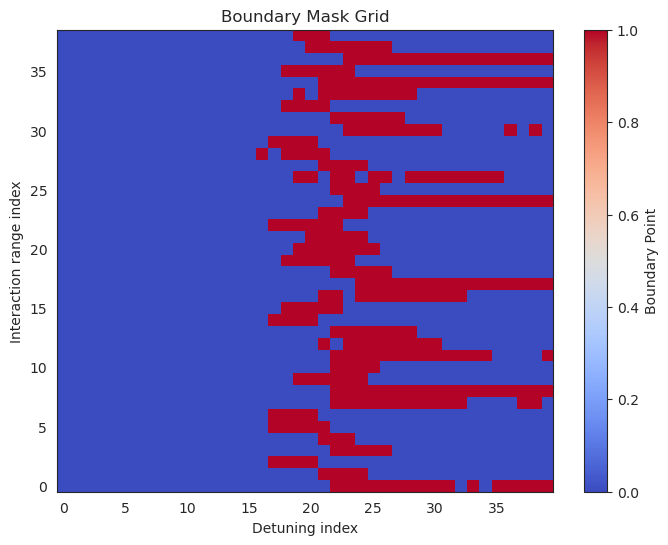

In [22]:
import matplotlib.pyplot as plt

# Reshape the boundary mask to 2D grid
boundary_grid = boundary_mask.values.reshape(df['interaction_range'].nunique(), df['detuning'].nunique())

plt.figure(figsize=(8, 6))
plt.imshow(boundary_grid, aspect='auto', cmap='coolwarm', origin='lower')
plt.xlabel('Detuning index')
plt.ylabel('Interaction range index')
plt.title('Boundary Mask Grid')
plt.colorbar(label='Boundary Point')
plt.show()

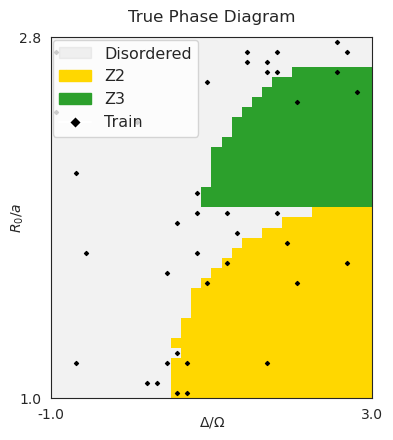

In [23]:
train_set, train_idxes = prepare_weighted_boundary_train_set(meta_dataset, n_samples=50)


all_idxes = set(meta_dataset.info.index)
# Get training indexes as a set
train_idxes_set = set(train_idxes)
# Find the rest (test/unused) indexes
rest_idxes = list(all_idxes - train_idxes_set)

data_train = meta_dataset.info.copy().loc[list(train_idxes)]
data_test = meta_dataset.info.copy().loc[rest_idxes]
data_test.describe()


# Filter train_idxes to only those present in plot_df
valid_train_idxes = [idx for idx in train_idxes if idx in plot_df.index]

fig_true = plot_phase_diagram(
    plot_df,
    title="True Phase Diagram",
    train_idxes=valid_train_idxes,
    hue_order=hue_order,
    legend=True
)

In [24]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

def compute_phase_boundaries(df, grid_resolution=50):
    """
    Compute phase boundaries using interpolation and edge detection
    
    Args:
        df: DataFrame with 'detuning', 'interaction_range', and 'phase' columns
        grid_resolution: Resolution of the interpolation grid
    
    Returns:
        boundary_points: Array of (x, y) coordinates representing boundary points
    """
    
    # Create regular grid
    x_min, x_max = df['detuning'].min(), df['detuning'].max()
    y_min, y_max = df['interaction_range'].min(), df['interaction_range'].max()
    
    xi = np.linspace(x_min, x_max, grid_resolution)
    yi = np.linspace(y_min, y_max, grid_resolution)
    XI, YI = np.meshgrid(xi, yi)
    
    # Encode phases as numbers
    le = LabelEncoder()
    phase_encoded = le.fit_transform(df['phase'])
    
    # Interpolate phases onto regular grid
    points = df[['detuning', 'interaction_range']].values
    values = phase_encoded
    
    # Use nearest neighbor for interpolation to preserve discrete phases
    ZI = griddata(points, values, (XI, YI), method='nearest', fill_value=0)
    
    # Find boundaries using gradient
    grad_x, grad_y = np.gradient(ZI.astype(float))
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Points where gradient is non-zero are boundaries
    boundary_mask = gradient_magnitude > 0.1
    
    # Extract boundary coordinates
    boundary_indices = np.where(boundary_mask)
    boundary_points = np.column_stack((
        XI[boundary_indices], 
        YI[boundary_indices]
    ))
    
    return boundary_points, XI, YI, ZI

def compute_distance_to_boundaries(df, boundary_points):
    """
    Compute minimum distance from each point to the nearest boundary
    
    Args:
        df: DataFrame with data points
        boundary_points: Array of boundary coordinates
    
    Returns:
        distances: Array of minimum distances to boundary for each point
    """
    
    data_points = df[['detuning', 'interaction_range']].values
    
    if len(boundary_points) == 0:
        return np.ones(len(df))  # If no boundaries found, return uniform distances
    
    # Compute distance from each data point to all boundary points
    distances = cdist(data_points, boundary_points)
    
    # Take minimum distance to any boundary point
    min_distances = np.min(distances, axis=1)
    
    return min_distances

def distance_to_probability(distances, decay_factor=2.0, min_prob_ratio=0.1):
    """
    Convert distances to sampling probabilities
    
    Args:
        distances: Array of distances to boundary
        decay_factor: How quickly probability decays with distance (higher = faster decay)
        min_prob_ratio: Minimum probability ratio (prevents zero probabilities)
    
    Returns:
        probabilities: Normalized sampling probabilities
    """
    
    # Inverse exponential decay: closer points get higher probability
    # Add small epsilon to avoid division by zero
    epsilon = 1e-6
    raw_weights = np.exp(-decay_factor * (distances + epsilon))
    
    # Ensure minimum probability
    max_weight = np.max(raw_weights)
    min_weight = max_weight * min_prob_ratio
    weights = np.maximum(raw_weights, min_weight)
    
    # Normalize to probabilities
    probabilities = weights / np.sum(weights)
    
    return probabilities

def prepare_distance_based_boundary_train_set(meta_dataset, n_samples=100, 
                                            decay_factor=2.0, min_prob_ratio=0.1,
                                            grid_resolution=50, plot_boundaries=False):
    """
    Prepare training set with probability based on distance to computed phase boundaries
    
    Args:
        meta_dataset: Your RydbergDataset
        n_samples: Number of samples to draw
        decay_factor: How quickly probability decays with distance to boundary
        min_prob_ratio: Minimum probability ratio for far points
        grid_resolution: Resolution for boundary computation
        plot_boundaries: Whether to plot the computed boundaries
    
    Returns:
        train_set: Training set dictionary
        train_idxes: Indices of selected training points
        boundary_info: Dictionary with boundary computation info
    """
    
    df = meta_dataset.info.copy()
    
    print("Computing phase boundaries...")
    boundary_points, XI, YI, ZI = compute_phase_boundaries(df, grid_resolution)
    print(f"Found {len(boundary_points)} boundary points")
    
    print("Computing distances to boundaries...")
    distances = compute_distance_to_boundaries(df, boundary_points)
    
    print("Converting distances to probabilities...")
    probabilities = distance_to_probability(distances, decay_factor, min_prob_ratio)
    
    # Sample indices with distance-based probabilities
    print(f"Sampling {n_samples} training points...")
    train_idxes = np.random.choice(
        df.index, 
        size=min(n_samples, len(df)), 
        replace=False, 
        p=probabilities
    )
    
    # Prepare training set
    train_keys = meta_dataset.keys[train_idxes]
    train_set = {}
    train_set.update(meta_dataset.prepare_train_set(train_keys, n_measurements=-1))
    
    # Prepare boundary info for visualization
    boundary_info = {
        'boundary_points': boundary_points,
        'distances': distances,
        'probabilities': probabilities,
        'XI': XI, 'YI': YI, 'ZI': ZI
    }
    
    if plot_boundaries:
        plot_boundary_sampling(df, train_idxes, boundary_info)
    
    print(f"Selected {len(train_idxes)} training points")
    print(f"Average distance to boundary: {np.mean(distances[train_idxes]):.4f}")
    print(f"Boundary points in sample: {np.sum(distances[train_idxes] < 0.05)}/{len(train_idxes)}")
    
    return train_set, train_idxes, boundary_info

def plot_boundary_sampling(df, train_idxes, boundary_info, figsize=(15, 5)):
    """
    Plot the computed boundaries and sampling results
    """
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Plot 1: Original phase diagram with computed boundaries
    ax1 = axes[0]
    scatter = ax1.scatter(df['detuning'], df['interaction_range'], 
                         c=df['phase'].astype('category').cat.codes, 
                         alpha=0.6, s=20, cmap='viridis')
    
    # Overlay boundary points
    boundary_points = boundary_info['boundary_points']
    if len(boundary_points) > 0:
        ax1.scatter(boundary_points[:, 0], boundary_points[:, 1], 
                   c='red', s=10, alpha=0.8, label='Computed Boundaries')
    
    ax1.set_xlabel('Detuning')
    ax1.set_ylabel('Interaction Range')
    ax1.set_title('Phase Diagram with Computed Boundaries')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Distance to boundaries (heatmap)
    ax2 = axes[1]
    distances = boundary_info['distances']
    scatter2 = ax2.scatter(df['detuning'], df['interaction_range'], 
                          c=distances, s=20, cmap='plasma_r', alpha=0.7)
    plt.colorbar(scatter2, ax=ax2, label='Distance to Boundary')
    ax2.set_xlabel('Detuning')
    ax2.set_ylabel('Interaction Range')
    ax2.set_title('Distance to Phase Boundaries')
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Selected training points
    ax3 = axes[2]
    # All points in light gray
    ax3.scatter(df['detuning'], df['interaction_range'], 
               c='lightgray', alpha=0.5, s=15, label='All data')
    
    # Selected training points in red
    train_points = df.loc[train_idxes]
    ax3.scatter(train_points['detuning'], train_points['interaction_range'],
               c='red', s=40, alpha=0.8, label='Selected training points')
    
    # Boundary points for reference
    if len(boundary_points) > 0:
        ax3.scatter(boundary_points[:, 0], boundary_points[:, 1], 
                   c='blue', s=5, alpha=0.6, label='Boundaries')
    
    ax3.set_xlabel('Detuning')
    ax3.set_ylabel('Interaction Range')
    ax3.set_title('Selected Training Points')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    selected_distances = distances[train_idxes]
    print(f"\nSampling Statistics:")
    print(f"Min distance in training set: {np.min(selected_distances):.4f}")
    print(f"Max distance in training set: {np.max(selected_distances):.4f}")
    print(f"Mean distance in training set: {np.mean(selected_distances):.4f}")
    print(f"Std distance in training set: {np.std(selected_distances):.4f}")
    
    # Compare with random sampling
    random_idxes = np.random.choice(df.index, size=len(train_idxes), replace=False)
    random_distances = distances[random_idxes]
    print(f"\nComparison with random sampling:")
    print(f"Mean distance (boundary sampling): {np.mean(selected_distances):.4f}")
    print(f"Mean distance (random sampling): {np.mean(random_distances):.4f}")
    print(f"Improvement factor: {np.mean(random_distances) / np.mean(selected_distances):.2f}x closer to boundaries")

# Example usage function
def compare_sampling_methods(meta_dataset, n_samples=100):
    """
    Compare the old threshold-based method with the new distance-based method
    """
    
    print("=== DISTANCE-BASED BOUNDARY SAMPLING ===")
    train_set_new, train_idxes_new, boundary_info = prepare_distance_based_boundary_train_set(
        meta_dataset, 
        n_samples=n_samples,
        decay_factor=3.0,  # Higher = more preference for boundary points
        min_prob_ratio=0.05,  # Minimum probability for far points
        plot_boundaries=True
    )
    
    return train_set_new, train_idxes_new, boundary_info

In [25]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.spatial.distance import cdist
from scipy.interpolate import griddata

def compute_phase_boundaries(df, grid_resolution=50):
    """
    Compute phase boundaries using interpolation and edge detection
    
    Args:
        df: DataFrame with 'detuning', 'interaction_range', and 'phase' columns
        grid_resolution: Resolution of the interpolation grid
    
    Returns:
        boundary_points: Array of (x, y) coordinates representing boundary points
    """
    
    # Create regular grid
    x_min, x_max = df['detuning'].min(), df['detuning'].max()
    y_min, y_max = df['interaction_range'].min(), df['interaction_range'].max()
    
    xi = np.linspace(x_min, x_max, grid_resolution)
    yi = np.linspace(y_min, y_max, grid_resolution)
    XI, YI = np.meshgrid(xi, yi)
    
    # Encode phases as numbers
    le = LabelEncoder()
    phase_encoded = le.fit_transform(df['phase'])
    
    # Interpolate phases onto regular grid
    points = df[['detuning', 'interaction_range']].values
    values = phase_encoded
    
    # Use nearest neighbor for interpolation to preserve discrete phases
    ZI = griddata(points, values, (XI, YI), method='nearest', fill_value=0)
    
    # Find boundaries using gradient
    grad_x, grad_y = np.gradient(ZI.astype(float))
    gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)
    
    # Points where gradient is non-zero are boundaries
    boundary_mask = gradient_magnitude > 0.1
    
    # Extract boundary coordinates
    boundary_indices = np.where(boundary_mask)
    boundary_points = np.column_stack((
        XI[boundary_indices], 
        YI[boundary_indices]
    ))
    
    return boundary_points

def compute_distance_to_boundaries(df, boundary_points):
    """
    Compute minimum distance from each point to the nearest boundary
    
    Args:
        df: DataFrame with data points
        boundary_points: Array of boundary coordinates
    
    Returns:
        distances: Array of minimum distances to boundary for each point
    """
    
    data_points = df[['detuning', 'interaction_range']].values
    
    if len(boundary_points) == 0:
        return np.ones(len(df))  # If no boundaries found, return uniform distances
    
    # Compute distance from each data point to all boundary points
    distances = cdist(data_points, boundary_points)
    
    # Take minimum distance to any boundary point
    min_distances = np.min(distances, axis=1)
    
    return min_distances

def distance_to_probability(distances, decay_factor=2.0, min_prob_ratio=0.1):
    """
    Convert distances to sampling probabilities
    
    Args:
        distances: Array of distances to boundary
        decay_factor: How quickly probability decays with distance (higher = faster decay)
        min_prob_ratio: Minimum probability ratio (prevents zero probabilities)
    
    Returns:
        probabilities: Normalized sampling probabilities
    """
    
    # Inverse exponential decay: closer points get higher probability
    # Add small epsilon to avoid division by zero
    epsilon = 1e-6
    raw_weights = np.exp(-decay_factor * (distances + epsilon))
    
    # Ensure minimum probability
    max_weight = np.max(raw_weights)
    min_weight = max_weight * min_prob_ratio
    weights = np.maximum(raw_weights, min_weight)
    
    # Normalize to probabilities
    probabilities = weights / np.sum(weights)
    
    return probabilities

def prepare_distance_based_boundary_train_set(meta_dataset, n_samples=100, 
                                            decay_factor=2.0, min_prob_ratio=0.1,
                                            grid_resolution=50):
    """
    Prepare training set with probability based on distance to computed phase boundaries
    
    Args:
        meta_dataset: Your RydbergDataset
        n_samples: Number of samples to draw
        decay_factor: How quickly probability decays with distance to boundary
        min_prob_ratio: Minimum probability ratio for far points
        grid_resolution: Resolution for boundary computation
    
    Returns:
        train_set: Training set dictionary
        train_idxes: Indices of selected training points
    """
    
    df = meta_dataset.info.copy()
    
    # Compute phase boundaries
    boundary_points = compute_phase_boundaries(df, grid_resolution)
    
    # Compute distances to boundaries
    distances = compute_distance_to_boundaries(df, boundary_points)
    
    # Convert distances to probabilities
    probabilities = distance_to_probability(distances, decay_factor, min_prob_ratio)
    
    # Sample indices with distance-based probabilities
    train_idxes = np.random.choice(
        df.index, 
        size=min(n_samples, len(df)), 
        replace=False, 
        p=probabilities
    )
    
    # Prepare training set
    train_keys = meta_dataset.keys[train_idxes]
    train_set = {}
    train_set.update(meta_dataset.prepare_train_set(train_keys, n_measurements=-1))
    
    return train_set, train_idxes

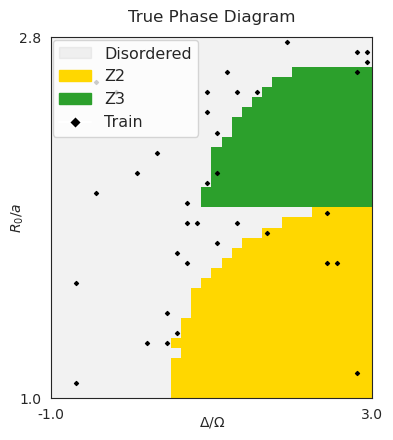

In [26]:
# train_set, train_idxes = prepare_distance_based_boundary_train_set(
#     meta_dataset,
#     n_samples=50,
#     decay_factor=3.0,  # Higher values = stronger preference for boundary points
#     min_prob_ratio=0.05,  # Minimum probability for distant points
#     plot_boundaries=True  # Show visualization
# )

train_set, train_idxes = prepare_distance_based_boundary_train_set(
    meta_dataset, 
    n_samples=50,
    decay_factor=2.0,
    min_prob_ratio=0.1
)


train_set, train_idxes = prepare_weighted_boundary_train_set(meta_dataset, n_samples=50)

all_idxes = set(meta_dataset.info.index)
# Get training indexes as a set
train_idxes_set = set(train_idxes)
# Find the rest (test/unused) indexes
rest_idxes = list(all_idxes - train_idxes_set)

data_train = meta_dataset.info.copy().loc[list(train_idxes)]
data_test = meta_dataset.info.copy().loc[rest_idxes]
data_test.describe()


# Filter train_idxes to only those present in plot_df
valid_train_idxes = [idx for idx in train_idxes if idx in plot_df.index]

fig_true = plot_phase_diagram(
    plot_df,
    title="True Phase Diagram",
    train_idxes=valid_train_idxes,
    hue_order=hue_order,
    legend=True
)

## We dont use Kernels here

Unlike the Rydberg_data file, here we do not make comparison between Generative model and our model
We are trying to compare the standard and PI-based approaches acccuracy

In [27]:
i = 0
while i < 10:
    if not train_idxes[i] in train_idxes_set:
        print('Fail')
        break
    i+=1

In [28]:
# Features only (no target variable)
X_train = data_train[['interaction_range', 'detuning']]
X_test = data_test[['interaction_range', 'detuning']]

# Target variable
Y_train = data_train['phase']
Y_test = data_test['phase']

# Privileged information (same indexes as X_train automatically)
X_star = data_train[['Z2', 'Z3', 'Z4']]

In [29]:
X_train.shape, X_test.shape, X_star.shape, Y_train.size

((50, 2), (1510, 2), (50, 3), 50)

### SVM+ where PI = (Z2, Z3, Z4)

In [30]:
# Set random seed for reproducibility (optional)
np.random.seed(6)

# Get the total number of training samples
n_samples = len(X_train)
N_train = 20

# Randomly select N_train indices
random_indices = np.random.choice(n_samples, size=N_train, replace=False)

# Select the same N_train random points from all datasets
X_train = X_train.iloc[random_indices]
X_star = X_star.iloc[random_indices]
Y_train = Y_train.iloc[random_indices]  # Use .iloc instead of direct indexing

In [31]:
Y_train.nunique()

2

In [32]:
# np.random.seed(42)
_, train_idxes = prepare_train_set(meta_dataset)
meta_dataset.info.copy().loc[list(train_idxes)]['phase'].nunique()

3

In [33]:
def choose_data_grid(N_train, seed = 42):
    # np.random.seed(seed)

    # make sure all phases are presented in the dataset
    _, train_idxes = prepare_train_set(meta_dataset)

    while meta_dataset.info.copy().loc[list(train_idxes)]['phase'].nunique() != 3:
        _, train_idxes = prepare_train_set(meta_dataset)


    all_idxes = set(meta_dataset.info.index)
    # Get training indexes as a set
    train_idxes_set = set(train_idxes)
    # Find the rest (test/unused) indexes
    rest_idxes = list(all_idxes - train_idxes_set)

    data_train = meta_dataset.info.copy().loc[list(train_idxes)]
    data_test = meta_dataset.info.copy().loc[rest_idxes]

    # Features only (no target variable)
    X_train = data_train[['interaction_range', 'detuning']]
    X_test = data_test[['interaction_range', 'detuning']]

    # Target variable
    Y_train = data_train['phase']
    Y_test = data_test['phase']

    # Privileged information (same indexes as X_train automatically)
    X_star = data_train[['Z2', 'Z3', 'Z4']]

    # Get the total number of training samples (remove later???)
    n_samples = len(X_train)

    # Randomly select N_train indices
    random_indices = np.random.choice(n_samples, size=N_train, replace=False)

    # Select the same N_train random points from all datasets
    X_train = X_train.iloc[random_indices]
    X_star = X_star.iloc[random_indices]
    Y_train = Y_train.iloc[random_indices] 

    return X_train, Y_train, X_test, Y_test, X_star

In [34]:
_, train_idxes = prepare_weighted_boundary_train_set(meta_dataset)


meta_dataset.info.copy().loc[list(train_idxes)]['phase'].nunique()


3

In [35]:
_, train_idxes = prepare_weighted_boundary_train_set(meta_dataset)
train_idxes = np.random.choice(train_idxes, size=N_train, replace=False)

while  meta_dataset.info.copy().loc[list(train_idxes)]['phase'].nunique() != 3:
    _, train_idxes = prepare_weighted_boundary_train_set(meta_dataset)

In [36]:
def choose_data(N_train, seed = 42):
    np.random.seed(seed)

    # make sure all phases are presented in the dataset
    all_idxes = set(meta_dataset.info.index)

    # IF YOU DONT NEED WEIGHTED BOUNDARY DATA, UNCOMMENT BELOW

    train_idxes = np.random.choice(len(all_idxes), size=N_train, replace=False)
    while  meta_dataset.info.copy().loc[list(train_idxes)]['phase'].nunique() != 3:
        train_idxes = np.random.choice(len(all_idxes), size=N_train, replace=False)

    # FOR WEIGHTED BOUNDARY DATA, UNCOMMENT BELOW

    # _, train_idxes = prepare_weighted_boundary_train_set(meta_dataset)
    # train_idxes = np.random.choice(train_idxes, size=N_train, replace=False)
    
    # _, train_idxes = prepare_distance_based_boundary_train_set(meta_dataset)
    # train_idxes = np.random.choice(train_idxes, size=N_train, replace=False)

    while  meta_dataset.info.copy().loc[list(train_idxes)]['phase'].nunique() != 3:
        _, train_idxes = prepare_weighted_boundary_train_set(meta_dataset)

    # print('Choice completed')
    
    # Get training indexes as a set
    train_idxes_set = set(train_idxes)
    # Find the rest (test/unused) indexes
    rest_idxes = list(all_idxes - train_idxes_set)

    data_train = meta_dataset.info.copy().loc[list(train_idxes)]
    data_test = meta_dataset.info.copy().loc[rest_idxes]

    # Features only (no target variable)
    X_train = data_train[['interaction_range', 'detuning']]
    X_test = data_test[['interaction_range', 'detuning']]

    # Target variable
    Y_train = data_train['phase']
    Y_test = data_test['phase']

    # Privileged information (same indexes as X_train automatically)
    X_star = data_train[['Z2', 'Z3', 'Z4']]

    return X_train, Y_train, X_test, Y_test, X_star

In [37]:
def prepare_data(X_train, Y_train, X_test, Y_test, X_star):
    """
    Prepare and standardize the data for training
    """
    # Convert to numpy arrays if they're pandas objects
    X_train_np = X_train.values if hasattr(X_train, 'values') else np.array(X_train)
    X_test_np = X_test.values if hasattr(X_test, 'values') else np.array(X_test)
    X_star_np = X_star.values if hasattr(X_star, 'values') else np.array(X_star)
    Y_train_np = Y_train.values if hasattr(Y_train, 'values') else np.array(Y_train)
    Y_test_np = Y_test.values if hasattr(Y_test, 'values') else np.array(Y_test)
    
    # Standardize features
    scaler_X = StandardScaler()
    scaler_X_star = StandardScaler()
    
    X_train_scaled = scaler_X.fit_transform(X_train_np)
    X_test_scaled = scaler_X.transform(X_test_np)
    X_star_scaled = scaler_X_star.fit_transform(X_star_np)
    
    return X_train_scaled, X_test_scaled, X_star_scaled, Y_train_np, Y_test_np, scaler_X, scaler_X_star

def train_standard_svm(X_train, Y_train, X_test, Y_test):
    """
    Train standard multiclass SVM with hyperparameter tuning
    """
    print("Training Standard SVM...")
    
    # Define parameter grid for grid search
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'kernel': ['rbf', 'poly', 'linear']
    }
    
    # Create SVM classifier
    svm = SVC(random_state=42)
    
    # Perform grid search
    grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    
    # Get best model
    best_svm = grid_search.best_estimator_
    
    # Make predictions
    y_pred_train = best_svm.predict(X_train)
    y_pred_test = best_svm.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(Y_train, y_pred_train)
    test_accuracy = accuracy_score(Y_test, y_pred_test)
    
    print(f"Best SVM parameters: {grid_search.best_params_}")
    print(f"Standard SVM - Train Accuracy: {train_accuracy:.4f}")
    print(f"Standard SVM - Test Accuracy: {test_accuracy:.4f}")
    
    return best_svm, y_pred_test, train_accuracy, test_accuracy, grid_search.best_params_

def train_svm_plus(X_train, X_star, Y_train, X_test, Y_test):
    """
    Train SVM+ with hyperparameter tuning
    """
    print("\nTraining SVM+ with Privileged Information...")
    
    # Define parameter grid for SVM+
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'linear'],
        'kernel_star': ['rbf', 'linear']
    }
    
    best_accuracy = 0
    best_params = None
    best_model = None
    
    # Manual grid search for SVM+ (since it doesn't work directly with sklearn's GridSearchCV)
    for C in param_grid['C']:
        for gamma in param_grid['gamma']:
            for kernel in param_grid['kernel']:
                for kernel_star in param_grid['kernel_star']:
                    try:
                        # Create and train SVM+ model
                        svm_plus = MulticlassSVMplus(
                            C=C, gamma=gamma, kernel=kernel, kernel_star=kernel_star,
                            tol=1e-6, max_iter=1000
                        )
                        svm_plus.fit(X_train, X_star, Y_train)
                        
                        # Predict on training set for validation
                        y_pred_train = svm_plus.predict(X_train)
                        train_accuracy = accuracy_score(Y_train, y_pred_train)
                        
                        # Keep track of best model
                        if train_accuracy > best_accuracy:
                            best_accuracy = train_accuracy
                            best_params = {'C': C, 'gamma': gamma, 'kernel': kernel, 'kernel_star': kernel_star}
                            best_model = svm_plus
                            
                    except Exception as e:
                        # Skip parameter combinations that cause errors
                        continue
    
    if best_model is None:
        print("Warning: No SVM+ model could be trained successfully. Using default parameters.")
        best_model = MulticlassSVMplus(C=1.0, gamma=1.0, kernel='rbf', kernel_star='rbf')
        best_model.fit(X_train, X_star, Y_train)
        best_params = {'C': 1.0, 'gamma': 1.0, 'kernel': 'rbf', 'kernel_star': 'rbf'}
    
    # Make predictions
    y_pred_train = best_model.predict(X_train)
    y_pred_test = best_model.predict(X_test)
    
    # Calculate accuracies
    train_accuracy = accuracy_score(Y_train, y_pred_train)
    test_accuracy = accuracy_score(Y_test, y_pred_test)
    
    print(f"Best SVM+ parameters: {best_params}")
    print(f"SVM+ - Train Accuracy: {train_accuracy:.4f}")
    print(f"SVM+ - Test Accuracy: {test_accuracy:.4f}")
    
    return best_model, y_pred_test, train_accuracy, test_accuracy, best_params

def plot_results(svm_train_acc, svm_test_acc, svm_plus_train_acc, svm_plus_test_acc):
    """
    Plot training and test accuracy comparison
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    
    # Data for plotting - grouped by accuracy type
    accuracy_types = ['Training Accuracy', 'Test Accuracy']
    svm_accuracies = [svm_train_acc, svm_test_acc]
    svm_plus_accuracies = [svm_plus_train_acc, svm_plus_test_acc]
    
    # Set width of bars and positions
    bar_width = 0.35
    x_pos = np.arange(len(accuracy_types))
    
    # Create bars
    bars1 = ax.bar(x_pos - bar_width/2, svm_accuracies, bar_width, 
                   label='Standard SVM', color='skyblue', alpha=0.8)
    bars2 = ax.bar(x_pos + bar_width/2, svm_plus_accuracies, bar_width,
                   label='SVM+', color='lightgreen', alpha=0.8)
    
    # Customize plot
    ax.set_xlabel('Accuracy Type')
    ax.set_ylabel('Accuracy')
    ax.set_title('Training and Test Accuracy Comparison')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(accuracy_types)
    ax.set_ylim(0, 1.15)  # More free space above columns
    ax.legend()
    
    # Add accuracy values on bars
    for bar, acc in zip(bars1, svm_accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    for bar, acc in zip(bars2, svm_plus_accuracies):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def generate_detailed_report(Y_test, y_pred_svm, y_pred_svm_plus, 
                           svm_params, svm_plus_params,
                           svm_train_acc, svm_test_acc, 
                           svm_plus_train_acc, svm_plus_test_acc):
    """
    Generate simple comparison report
    """
    print("\n" + "="*50)
    print("RESULTS SUMMARY")
    print("="*50)
    
    print(f"\nStandard SVM Test Accuracy: {svm_test_acc:.3f}")
    print(f"SVM+ Test Accuracy:         {svm_plus_test_acc:.3f}")
    
    improvement = svm_plus_test_acc - svm_test_acc
    print(f"Improvement:                {improvement:+.3f}")
    
    if improvement > 0.01:  # More than 1% improvement
        print(f"\n✓ SVM+ performs better by {improvement*100:.1f}%")
        print("✓ Privileged information is helpful")
    elif improvement < -0.01:  # More than 1% degradation
        print(f"\n✗ SVM+ performs worse by {abs(improvement)*100:.1f}%")
        print("✗ Privileged information is not helpful")
    else:
        print(f"\n≈ Performance is similar (difference < 1%)")
        print("≈ Privileged information has minimal impact")
    
    print(f"\nBest parameters:")
    print(f"  Standard SVM: C={svm_params.get('C', 'N/A')}, kernel={svm_params.get('kernel', 'N/A')}")
    print(f"  SVM+: C={svm_plus_params.get('C', 'N/A')}, gamma={svm_plus_params.get('gamma', 'N/A')}")
    print("="*50)

def main(X_train, Y_train, X_test, Y_test, X_star, detailed = False):
    """
    Main function to run the complete comparison
    """
    if detailed:
        print("Comparing Standard SVM vs SVM+ with Privileged Information")
        print("="*55)
    
    # Prepare data
    X_train_scaled, X_test_scaled, X_star_scaled, Y_train_np, Y_test_np, scaler_X, scaler_X_star = prepare_data(
        X_train, Y_train, X_test, Y_test, X_star
    )
    if detailed:
        print(f"Dataset: {X_train_scaled.shape[0]} train, {X_test_scaled.shape[0]} test samples")
        print(f"Features: {X_train_scaled.shape[1]} regular, {X_star_scaled.shape[1]} privileged")
        print(f"Classes: {len(np.unique(Y_train_np))}")
    
    # Train Standard SVM
    svm_model, y_pred_svm, svm_train_acc, svm_test_acc, svm_params = train_standard_svm(
        X_train_scaled, Y_train_np, X_test_scaled, Y_test_np
    )
    
    # Train SVM+
    svm_plus_model, y_pred_svm_plus, svm_plus_train_acc, svm_plus_test_acc, svm_plus_params = train_svm_plus(
        X_train_scaled, X_star_scaled, Y_train_np, X_test_scaled, Y_test_np
    )
    
    # Simple results report
    if detailed:
        generate_detailed_report(
            Y_test_np, y_pred_svm, y_pred_svm_plus,
            svm_params, svm_plus_params,
            svm_train_acc, svm_test_acc,
            svm_plus_train_acc, svm_plus_test_acc
        )
    
        # Plot comparison with both training and test accuracies
        plot_results(svm_train_acc, svm_test_acc, svm_plus_train_acc, svm_plus_test_acc)
    
    return {
        'svm_accuracy': svm_test_acc,
        'svm_plus_accuracy': svm_plus_test_acc,
        'improvement': svm_plus_test_acc - svm_test_acc,
        'models': {'svm': svm_model, 'svm_plus': svm_plus_model}
    }

In [38]:
# Simple Usage Example
N_train = 15
X_train, Y_train, X_test, Y_test, X_star = choose_data(N_train, seed=2)


# Run the comparison with your data:
results = main(X_train, Y_train, X_test, Y_test, X_star)
print(results)

Training Standard SVM...
Best SVM parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Standard SVM - Train Accuracy: 1.0000
Standard SVM - Test Accuracy: 0.8654

Training SVM+ with Privileged Information...
Best SVM+ parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf', 'kernel_star': 'rbf'}
SVM+ - Train Accuracy: 1.0000
SVM+ - Test Accuracy: 0.8168
{'svm_accuracy': 0.8653721682847897, 'svm_plus_accuracy': 0.8168284789644013, 'improvement': -0.04854368932038844, 'models': {'svm': SVC(C=10, kernel='linear', random_state=42), 'svm_plus': MulticlassSVMplus(C=1, gamma=0.1, kernel_params={}, kernel_star_params={})}}


In [39]:
from tqdm import tqdm

def get_accuracies(N_train, N_seeds):
    seeds = np.random.randint(1, 500, N_seeds)
    
    svm_acc = []
    svm_plus_acc = []
    impr = []
    
    # Create progress bar with initial description
    pbar = tqdm(seeds, desc="Processing seeds")
    
    for i, seed in enumerate(pbar):
        # Update description for current iteration
        pbar.set_description(f"Processing seed {i+1}/{N_seeds}")
        
        X_train, Y_train, X_test, Y_test, X_star = choose_data(N_train, seed=seed)
        res = main(X_train, Y_train, X_test, Y_test, X_star)
        svm_acc.append(res["svm_accuracy"])
        svm_plus_acc.append(res["svm_plus_accuracy"])
        impr.append(res["improvement"])
    
    return [svm_acc, svm_plus_acc, impr]

# RUN TO CHECK

# exp_results = get_accuracies(20, 2)

In [40]:
# COMPUTING ACCURACIES FOR DIFFERENT SIZE OF THE TRAINING DATASET
# RUN IF NEED NEW DATA

# N_train_list = [20, 30, 40]
# N_seeds = 30
# exp_results = {}

# for N_train in N_train_list: 
#     exp_results[(N_train, N_seeds)] = get_accuracies(N_train, N_seeds)


In [41]:
import pickle 
import os

filename = 'exp_res_big_1.pkl'

if os.path.exists(filename): 
    print('the file exists')
    with open(filename, 'rb') as f: 
        exp_results = pickle.load(f)
else:
    with open(filename, 'wb') as f: 
        pickle.dump(exp_results, f)
        print('data saved')

exp_results


the file exists


{(20,
  30): [[0.8253246753246753,
   0.8435064935064935,
   0.9292207792207792,
   0.9025974025974026,
   0.8655844155844156,
   0.8987012987012987,
   0.8474025974025974,
   0.9357142857142857,
   0.7733766233766234,
   0.8909090909090909,
   0.9058441558441559,
   0.875974025974026,
   0.9175324675324675,
   0.9071428571428571,
   0.9064935064935065,
   0.8935064935064935,
   0.8175324675324676,
   0.8727272727272727,
   0.8006493506493506,
   0.6538961038961039,
   0.8435064935064935,
   0.8363636363636363,
   0.8603896103896104,
   0.8954545454545455,
   0.875974025974026,
   0.8584415584415584,
   0.8597402597402597,
   0.7363636363636363,
   0.8506493506493507,
   0.8655844155844156], [0.8909090909090909,
   0.9253246753246753,
   0.837012987012987,
   0.9415584415584416,
   0.8785714285714286,
   0.8974025974025974,
   0.9402597402597402,
   0.9168831168831169,
   0.7435064935064936,
   0.8720779220779221,
   0.9058441558441559,
   0.9311688311688312,
   0.8909090909090909,
   

### Statistics computation

In [72]:
with open('exp_res_bdn_big_1.pkl', 'rb') as f1, \
     open('exp_res_bdn_big_2.pkl', 'rb') as f2, \
     open('exp_res_bdn_big_3.pkl', 'rb') as f3:
    exp_results = {**pickle.load(f1), **pickle.load(f2), **pickle.load(f3)}

In [73]:
exp_results.keys(), len(exp_results[(20,30)][0])

(dict_keys([(20, 30), (30, 30), (40, 30), (50, 30), (60, 30), (70, 30), (80, 30), (90, 30), (100, 30)]),
 30)

In [74]:
# SVM RESULTS
np.array(exp_results[(20,30)][0]).mean(), np.array(exp_results[(30,30)][0]).mean(), np.array(exp_results[(40,30)][0]).mean()

(np.float64(0.8361353258613534),
 np.float64(0.8705224281493419),
 np.float64(0.8887499999999998))

In [75]:
# SVM+ RESULTS
np.array(exp_results[(20,30)][1]).mean(), np.array(exp_results[(30,30)][1]).mean(), np.array(exp_results[(40,30)][1]).mean()

(np.float64(0.8865815691158158),
 np.float64(0.9054036469991346),
 np.float64(0.9204385964912282))

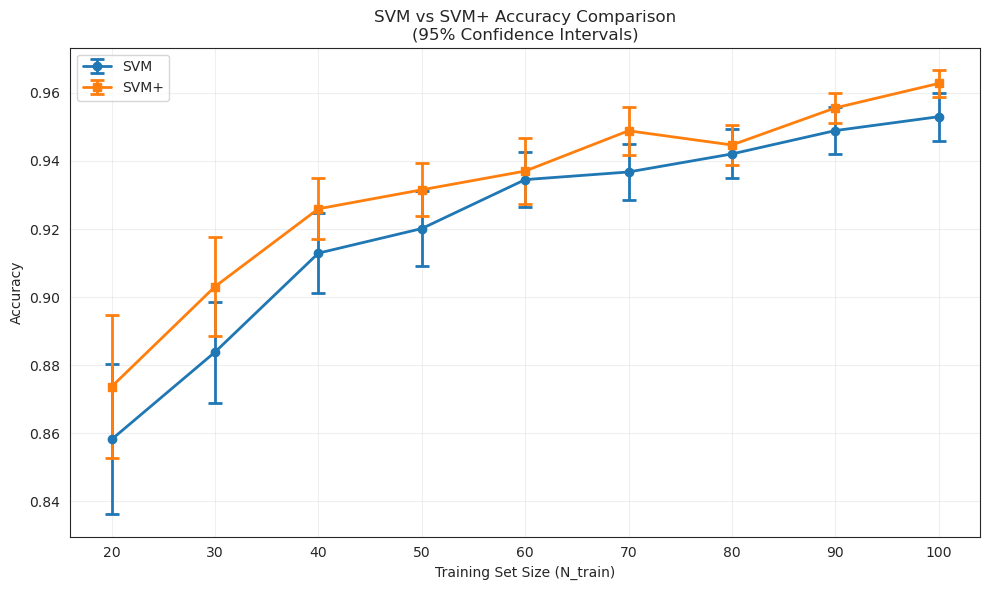

In [41]:
from scipy import stats as t
import matplotlib.pyplot as plt
import seaborn as sns


def plot_existing_results(results_dict, N_train_list,  N_seeds, confidence_level=0.95):
    """
    Plot results from already computed accuracies
    
    Args:
        results_dict: Dictionary with keys as N_train values, values as [svm_acc, svm_plus_acc, impr]
        N_train_list: List of N_train values to plot
        confidence_level: Confidence level for intervals
    """
    
    n_train_values = []
    svm_means = []
    svm_plus_means = []
    svm_errors = []
    svm_plus_errors = []
    
    alpha = 1 - confidence_level
    
    for N_train in N_train_list:
        if (N_train, N_seeds) not in results_dict:
            continue
            
        svm_acc, svm_plus_acc, _ = results_dict[(N_train, N_seeds)]
        
        n = len(svm_acc)
        
        # SVM statistics
        svm_mean = np.mean(svm_acc)
        svm_std = np.std(svm_acc, ddof=1)
        svm_sem = svm_std / np.sqrt(n)
        
        # SVM+ statistics
        svm_plus_mean = np.mean(svm_plus_acc)
        svm_plus_std = np.std(svm_plus_acc, ddof=1)
        svm_plus_sem = svm_plus_std / np.sqrt(n)
        
        # Confidence intervals
        t_critical = t.t.ppf(1 - alpha/2, n - 1)
        svm_error = t_critical * svm_sem
        svm_plus_error = t_critical * svm_plus_sem
        
        # Store results
        n_train_values.append(N_train)
        svm_means.append(svm_mean)
        svm_plus_means.append(svm_plus_mean)
        svm_errors.append(svm_error)
        svm_plus_errors.append(svm_plus_error)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot with error bars
    ax.errorbar(n_train_values, svm_means, yerr=svm_errors,
                label='SVM', marker='o', capsize=5, capthick=2, linewidth=2)
    
    ax.errorbar(n_train_values, svm_plus_means, yerr=svm_plus_errors,
                label='SVM+', marker='s', capsize=5, capthick=2, linewidth=2)
    
    ax.set_xlabel('Training Set Size (N_train)')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'SVM vs SVM+ Accuracy Comparison\n({confidence_level*100:.0f}% Confidence Intervals)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# If you already have results stored in exp_results
N_train_list_total = [20,30,40,50,60,70, 80, 90, 100]
# N_train_list_total = [20,30,40,50,60,70]
N_seeds = 30
plot_existing_results(exp_results, N_train_list_total, N_seeds)

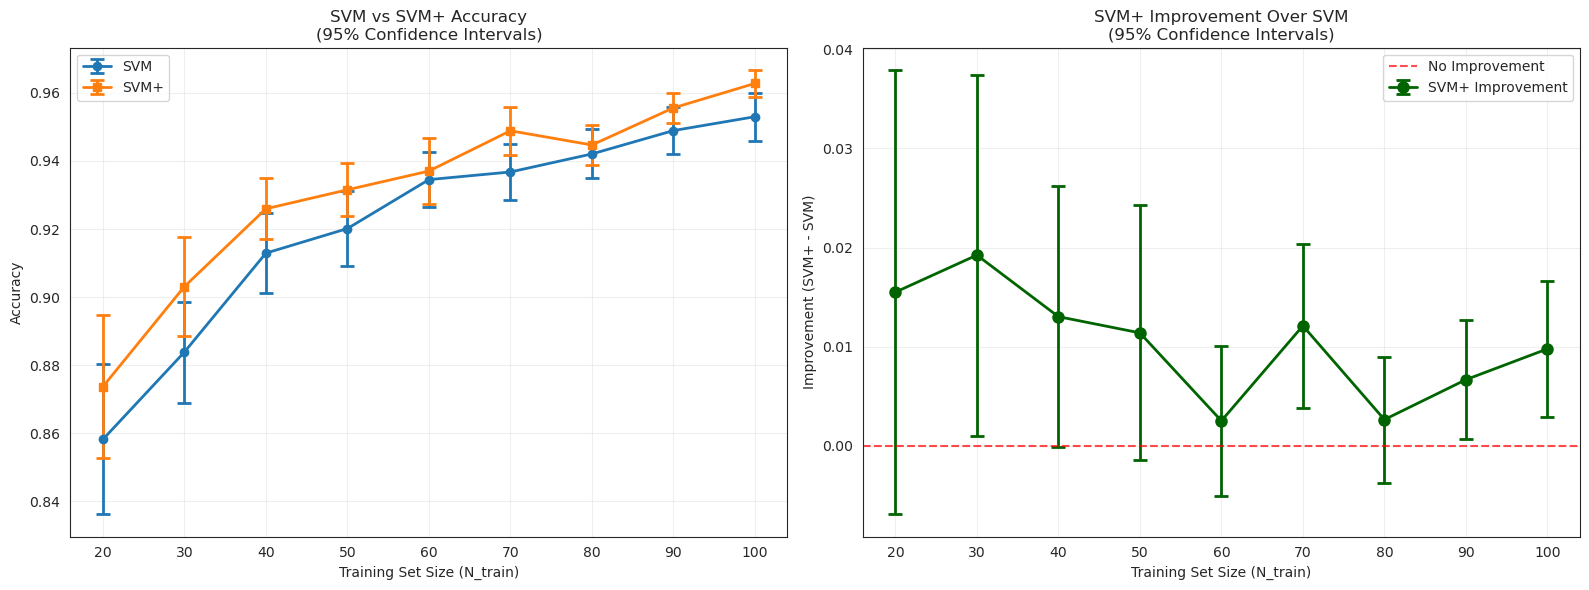


Summary Statistics:
N_train  SVM Mean   SVM+ Mean  Improvement  Impr 95% CI         
----------------------------------------------------------------------
20       0.8582     0.8737     0.0155       [-0.0069, 0.0379]
30       0.8839     0.9031     0.0192       [0.0010, 0.0375]
40       0.9129     0.9259     0.0130       [-0.0002, 0.0262]
50       0.9201     0.9315     0.0114       [-0.0015, 0.0243]
60       0.9345     0.9370     0.0025       [-0.0051, 0.0101]
70       0.9368     0.9489     0.0121       [0.0038, 0.0204]
80       0.9420     0.9447     0.0026       [-0.0037, 0.0090]
90       0.9489     0.9556     0.0067       [0.0007, 0.0127]
100      0.9530     0.9628     0.0098       [0.0029, 0.0166]


In [42]:
def plot_existing_results(results_dict, N_train_list, N_seeds, confidence_level=0.95):
    """
    Plot results from already computed accuracies with two subplots
    
    Args:
        results_dict: Dictionary with keys as N_train values, values as [svm_acc, svm_plus_acc, impr]
        N_train_list: List of N_train values to plot
        N_seeds: Number of seeds used
        confidence_level: Confidence level for intervals
    """
    
    n_train_values = []
    svm_means = []
    svm_plus_means = []
    svm_errors = []
    svm_plus_errors = []
    improvement_means = []
    improvement_errors = []
    
    alpha = 1 - confidence_level
    
    for N_train in N_train_list:
        # Fixed the key access and syntax error
        if (N_train, N_seeds) not in results_dict:
            continue
            
        svm_acc, svm_plus_acc, improvements = results_dict[(N_train, N_seeds)]
        
        n = len(svm_acc)
        
        # SVM statistics
        svm_mean = np.mean(svm_acc)
        svm_std = np.std(svm_acc, ddof=1)
        svm_sem = svm_std / np.sqrt(n)
        
        # SVM+ statistics
        svm_plus_mean = np.mean(svm_plus_acc)
        svm_plus_std = np.std(svm_plus_acc, ddof=1)
        svm_plus_sem = svm_plus_std / np.sqrt(n)
        
        # Improvement statistics
        impr_mean = np.mean(improvements)
        impr_std = np.std(improvements, ddof=1)
        impr_sem = impr_std / np.sqrt(n)
        
        # Confidence intervals
        t_critical = t.t.ppf(1 - alpha/2, n - 1)
        svm_error = t_critical * svm_sem
        svm_plus_error = t_critical * svm_plus_sem
        impr_error = t_critical * impr_sem
        
        # Store results
        n_train_values.append(N_train)
        svm_means.append(svm_mean)
        svm_plus_means.append(svm_plus_mean)
        svm_errors.append(svm_error)
        svm_plus_errors.append(svm_plus_error)
        improvement_means.append(impr_mean)
        improvement_errors.append(impr_error)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left subplot: Accuracies
    ax1.errorbar(n_train_values, svm_means, yerr=svm_errors,
                label='SVM', marker='o', capsize=5, capthick=2, linewidth=2)
    
    ax1.errorbar(n_train_values, svm_plus_means, yerr=svm_plus_errors,
                label='SVM+', marker='s', capsize=5, capthick=2, linewidth=2)
    
    ax1.set_xlabel('Training Set Size (N_train)')
    ax1.set_ylabel('Accuracy')
    ax1.set_title(f'SVM vs SVM+ Accuracy\n({confidence_level*100:.0f}% Confidence Intervals)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Right subplot: Improvements
    ax2.errorbar(n_train_values, improvement_means, yerr=improvement_errors,
                marker='o', markersize=8, capsize=5, capthick=2, linewidth=2, 
                color='darkgreen', label='SVM+ Improvement')
    
    # Reference line at zero
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7, label='No Improvement')
    
    ax2.set_xlabel('Training Set Size (N_train)')
    ax2.set_ylabel('Improvement (SVM+ - SVM)')
    ax2.set_title(f'SVM+ Improvement Over SVM\n({confidence_level*100:.0f}% Confidence Intervals)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary Statistics:")
    print(f"{'N_train':<8} {'SVM Mean':<10} {'SVM+ Mean':<10} {'Improvement':<12} {'Impr 95% CI':<20}")
    print("-" * 70)
    
    for i, N_train in enumerate(n_train_values):
        ci_lower = improvement_means[i] - improvement_errors[i]
        ci_upper = improvement_means[i] + improvement_errors[i]
        
        print(f"{N_train:<8.0f} {svm_means[i]:<10.4f} {svm_plus_means[i]:<10.4f} "
              f"{improvement_means[i]:<12.4f} [{ci_lower:.4f}, {ci_upper:.4f}]")

# Usage
N_train_list_total = [20, 30, 40, 50, 60, 70, 80, 90, 100]
N_seeds = 30
plot_existing_results(exp_results, N_train_list_total, N_seeds)

In [51]:
# Uncomment this for N_seeds = 30
# with open('exp_res_bdn_big_1.pkl', 'rb') as f1, \
#      open('exp_res_bdn_big_2.pkl', 'rb') as f2, \
#      open('exp_res_bdn_big_3.pkl', 'rb') as f3:
#     exp_results_bdn = {**pickle.load(f1), **pickle.load(f2), **pickle.load(f3)}

# with open('exp_res_big_1.pkl', 'rb') as f1, \
#      open('exp_res_big_2.pkl', 'rb') as f2, \
#      open('exp_res_big_3.pkl', 'rb') as f3:
#     exp_results_no = {**pickle.load(f1), **pickle.load(f2), **pickle.load(f3)}

# Uncomment this for N_seeds = 10
with open('exp_res_bd_1.pkl', 'rb') as f1, \
     open('exp_res_bd_2.pkl', 'rb') as f2, \
     open('exp_res_bd_3.pkl', 'rb') as f3:
    exp_results_bdn = {**pickle.load(f1), **pickle.load(f2), **pickle.load(f3)}

with open('exp_res_1.pkl', 'rb') as f1, \
     open('exp_res_2.pkl', 'rb') as f2, \
     open('exp_res_3.pkl', 'rb') as f3:
    exp_results_no = {**pickle.load(f1), **pickle.load(f2), **pickle.load(f3)}

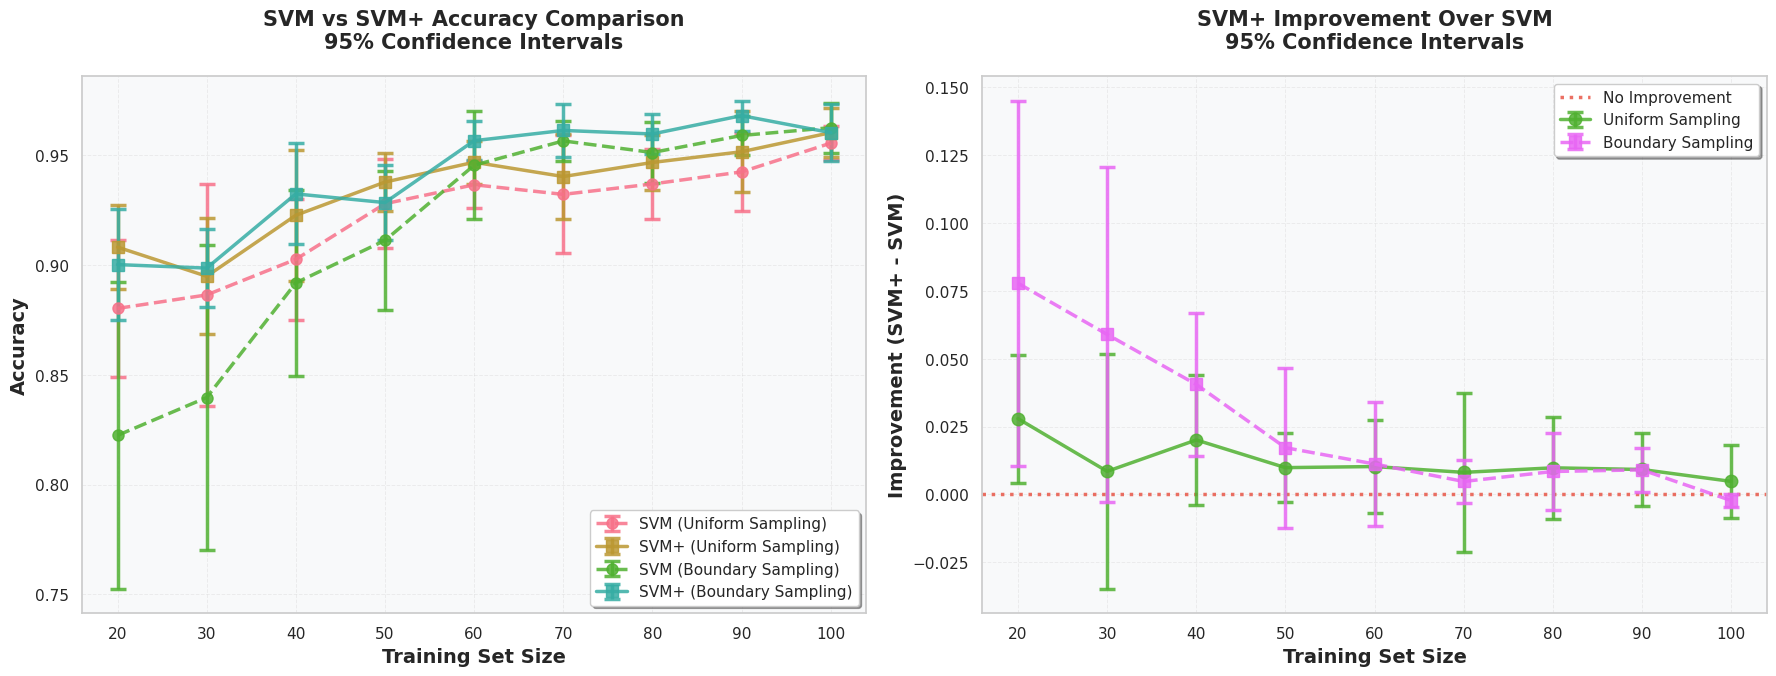


                    COMPARATIVE SUMMARY STATISTICS                    
N_train    Uniform Sampling Impr Boundary Sampling Impr Difference     
----------------------------------------------------------------------
20         0.02792         0.07782         0.04989        
30         0.00850         0.05895         0.05046        
40         0.02007         0.04053         0.02046        
50         0.00987         0.01722         0.00735        
60         0.01027         0.01120         0.00093        
70         0.00812         0.00477         -0.00336       
80         0.00980         0.00845         -0.00135       
90         0.00918         0.00905         -0.00014       
100        0.00479         -0.00226        -0.00705       
----------------------------------------------------------------------

                          OVERALL STATISTICS                          
    Uniform Sampling:    0.01206 ± 0.00682
   Boundary Sampling:    0.02508 ± 0.02607
  Average Difference:    

In [57]:
from scipy import stats as t
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_comparison_results(results_dict1, results_dict2, N_train_list, N_seeds, 
                           label1="Method 1", label2="Method 2", confidence_level=0.95):
    """
    Plot and compare results from two different methods with beautiful seaborn styling
    
    Args:
        results_dict1: First dictionary with keys as N_train values, values as [svm_acc, svm_plus_acc, impr]
        results_dict2: Second dictionary with keys as N_train values, values as [svm_acc, svm_plus_acc, impr]
        N_train_list: List of N_train values to plot
        N_seeds: Number of seeds used
        label1: Label for first method
        label2: Label for second method
        confidence_level: Confidence level for intervals
    """
    
    # Set seaborn style
    sns.set_style("whitegrid")
    sns.set_context("notebook", font_scale=1.2)
    
    # Define color palette
    colors = sns.color_palette("husl", 6)
    
    # Storage for method 1
    n_train_values = []
    svm1_means = []
    svm1_plus_means = []
    svm1_errors = []
    svm1_plus_errors = []
    improvement1_means = []
    improvement1_errors = []
    
    # Storage for method 2
    svm2_means = []
    svm2_plus_means = []
    svm2_errors = []
    svm2_plus_errors = []
    improvement2_means = []
    improvement2_errors = []
    
    alpha = 1 - confidence_level
    
    for N_train in N_train_list:
        # Check if both dictionaries have this key
        if (N_train, N_seeds) not in results_dict1 or (N_train, N_seeds) not in results_dict2:
            continue
        
        n_train_values.append(N_train)
        
        # Process Method 1
        svm_acc1, svm_plus_acc1, improvements1 = results_dict1[(N_train, N_seeds)]
        n1 = len(svm_acc1)
        
        svm1_mean = np.mean(svm_acc1)
        svm1_std = np.std(svm_acc1, ddof=1)
        svm1_sem = svm1_std / np.sqrt(n1)
        
        svm1_plus_mean = np.mean(svm_plus_acc1)
        svm1_plus_std = np.std(svm_plus_acc1, ddof=1)
        svm1_plus_sem = svm1_plus_std / np.sqrt(n1)
        
        impr1_mean = np.mean(improvements1)
        impr1_std = np.std(improvements1, ddof=1)
        impr1_sem = impr1_std / np.sqrt(n1)
        
        t_critical1 = t.t.ppf(1 - alpha/2, n1 - 1)
        svm1_error = t_critical1 * svm1_sem
        svm1_plus_error = t_critical1 * svm1_plus_sem
        impr1_error = t_critical1 * impr1_sem
        
        svm1_means.append(svm1_mean)
        svm1_plus_means.append(svm1_plus_mean)
        svm1_errors.append(svm1_error)
        svm1_plus_errors.append(svm1_plus_error)
        improvement1_means.append(impr1_mean)
        improvement1_errors.append(impr1_error)
        
        # Process Method 2
        svm_acc2, svm_plus_acc2, improvements2 = results_dict2[(N_train, N_seeds)]
        n2 = len(svm_acc2)
        
        svm2_mean = np.mean(svm_acc2)
        svm2_std = np.std(svm_acc2, ddof=1)
        svm2_sem = svm2_std / np.sqrt(n2)
        
        svm2_plus_mean = np.mean(svm_plus_acc2)
        svm2_plus_std = np.std(svm_plus_acc2, ddof=1)
        svm2_plus_sem = svm2_plus_std / np.sqrt(n2)
        
        impr2_mean = np.mean(improvements2)
        impr2_std = np.std(improvements2, ddof=1)
        impr2_sem = impr2_std / np.sqrt(n2)
        
        t_critical2 = t.t.ppf(1 - alpha/2, n2 - 1)
        svm2_error = t_critical2 * svm2_sem
        svm2_plus_error = t_critical2 * svm2_plus_sem
        impr2_error = t_critical2 * impr2_sem
        
        svm2_means.append(svm2_mean)
        svm2_plus_means.append(svm2_plus_mean)
        svm2_errors.append(svm2_error)
        svm2_plus_errors.append(svm2_plus_error)
        improvement2_means.append(impr2_mean)
        improvement2_errors.append(impr2_error)
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    
    # Left subplot: Accuracies (4 lines)
    # Method 1 - SVM
    ax1.errorbar(n_train_values, svm1_means, yerr=svm1_errors,
                label=f'SVM ({label1})', marker='o', markersize=8, capsize=6, 
                capthick=2.5, linewidth=2.5, linestyle='--', alpha=0.85, color=colors[0])
    
    # Method 1 - SVM+
    ax1.errorbar(n_train_values, svm1_plus_means, yerr=svm1_plus_errors,
                label=f'SVM+ ({label1})', marker='s', markersize=8, capsize=6, 
                capthick=2.5, linewidth=2.5, linestyle='-', alpha=0.85, color=colors[1])
    
    # Method 2 - SVM
    ax1.errorbar(n_train_values, svm2_means, yerr=svm2_errors,
                label=f'SVM ({label2})', marker='o', markersize=8, capsize=6, 
                capthick=2.5, linewidth=2.5, linestyle='--', alpha=0.85, color=colors[2])
    
    # Method 2 - SVM+
    ax1.errorbar(n_train_values, svm2_plus_means, yerr=svm2_plus_errors,
                label=f'SVM+ ({label2})', marker='s', markersize=8, capsize=6, 
                capthick=2.5, linewidth=2.5, linestyle='-', alpha=0.85, color=colors[3])
    
    ax1.set_xlabel('Training Set Size', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Accuracy', fontsize=14, fontweight='bold')
    ax1.set_title(f'SVM vs SVM+ Accuracy Comparison\n{confidence_level*100:.0f}% Confidence Intervals', 
                 fontsize=15, fontweight='bold', pad=20)
    ax1.legend(frameon=True, shadow=True, fancybox=True, fontsize=11, loc='best')
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
    ax1.tick_params(labelsize=11)
    
    # Add subtle background
    ax1.set_facecolor('#f8f9fa')
    
    # Right subplot: Improvements (2 lines)
    # Method 1 improvement
    ax2.errorbar(n_train_values, improvement1_means, yerr=improvement1_errors,
                marker='o', markersize=9, capsize=6, capthick=2.5, linewidth=2.5, 
                color=colors[2], label=f'{label1}', linestyle='-', alpha=0.85)
    
    # Method 2 improvement
    ax2.errorbar(n_train_values, improvement2_means, yerr=improvement2_errors,
                marker='s', markersize=9, capsize=6, capthick=2.5, linewidth=2.5, 
                color=colors[5], label=f'{label2}', linestyle='--', alpha=0.85)
    
    # Reference line at zero
    ax2.axhline(y=0, color='#e74c3c', linestyle=':', linewidth=2.5, alpha=0.8, 
               label='No Improvement', zorder=1)
    
    ax2.set_xlabel('Training Set Size', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Improvement (SVM+ - SVM)', fontsize=14, fontweight='bold')
    ax2.set_title(f'SVM+ Improvement Over SVM\n{confidence_level*100:.0f}% Confidence Intervals', 
                 fontsize=15, fontweight='bold', pad=20)
    ax2.legend(frameon=True, shadow=True, fancybox=True, fontsize=11, loc='best')
    ax2.grid(True, alpha=0.3, linestyle='--', linewidth=0.7)
    ax2.tick_params(labelsize=11)
    
    # Add subtle background
    ax2.set_facecolor('#f8f9fa')
    
    # Overall styling
    fig.patch.set_facecolor('white')
    plt.tight_layout()
    plt.show()
    
    # Print beautiful summary statistics
    print("\n" + "="*70)
    print(f"{'COMPARATIVE SUMMARY STATISTICS':^70}")
    print("="*70)
    print(f"{'N_train':<10} {label1 + ' Impr':<15} {label2 + ' Impr':<15} {'Difference':<15}")
    print("-"*70)
    
    for i, N_train in enumerate(n_train_values):
        diff = improvement2_means[i] - improvement1_means[i]
        print(f"{N_train:<10.0f} {improvement1_means[i]:<15.5f} {improvement2_means[i]:<15.5f} {diff:<15.5f}")
    
    print("-"*70)
    print(f"\n{'OVERALL STATISTICS':^70}")
    print("="*70)
    print(f"{label1:>20}: {np.mean(improvement1_means):>10.5f} ± {np.std(improvement1_means):.5f}")
    print(f"{label2:>20}: {np.mean(improvement2_means):>10.5f} ± {np.std(improvement2_means):.5f}")
    print(f"{'Average Difference':>20}: {np.mean(improvement2_means) - np.mean(improvement1_means):>10.5f}")
    print("="*70 + "\n")
    
    # Reset style
    sns.reset_defaults()

# Usage example
N_train_list_total = [20, 30, 40, 50, 60, 70, 80, 90, 100]
N_seeds = 10

plot_comparison_results(
    exp_results_no,  # First results dictionary
    exp_results_bdn,  # Second results dictionary
    N_train_list_total, 
    N_seeds,
    label1="Uniform Sampling",
    label2="Boundary Sampling"
)

In [54]:
from scipy.stats import t

# Basic statistics
improvements_array = exp_results_no[(20,10)][2]
n = len(improvements_array)
mean_imp = np.mean(improvements_array)
std_imp = np.std(improvements_array, ddof=1)
sem = std_imp / np.sqrt(n)

print(f"Sample size: {n}")
print(f"Mean improvement: {mean_imp:.6f}")
print(f"Standard deviation: {std_imp:.6f}")
print(f"Standard error: {sem:.6f}")

# t-statistic for H0: mean = 0
t_stat = mean_imp / sem
df = n - 1

print(f"t-statistic: {t_stat:.4f}")
print(f"Degrees of freedom: {df}")

# p-value (two-tailed)
p_value = 2 * (1 - t.cdf(abs(t_stat), df))
print(f"p-value (two-tailed): {p_value:.6f}")

# 95% confidence interval
alpha = 0.05
t_critical = t.ppf(1 - alpha/2, df)
ci_lower = mean_imp - t_critical * sem
ci_upper = mean_imp + t_critical * sem

print(f"95% CI: [{ci_lower:.6f}, {ci_upper:.6f}]")

# Interpretation
print(f"\nStatistical Significance:")
if p_value < 0.05:
    print(f"YES - p < 0.05 (p = {p_value:.6f})")
else:
    print(f"NO - p >= 0.05 (p = {p_value:.6f})")

Sample size: 10
Mean improvement: 0.027922
Standard deviation: 0.032989
Standard error: 0.010432
t-statistic: 2.6766
Degrees of freedom: 9
p-value (two-tailed): 0.025347
95% CI: [0.004323, 0.051521]

Statistical Significance:
YES - p < 0.05 (p = 0.025347)


In [56]:
from scipy import stats
import numpy as np

def test_improvements_ttest(results_dict1, results_dict2, N_train_list, N_seeds, 
                           label1="Method 1", label2="Method 2"):
    """
    Simple t-test: Test if improvements are significantly different from zero
    
    H0: improvement = 0
    H1: improvement ≠ 0
    """
    
    print("\n" + "="*70)
    print(f"T-TEST RESULTS (n={N_seeds})")
    print("="*70)
    print(f"H0: Improvement = 0 (no difference between SVM+ and SVM)")
    print("="*70 + "\n")
    
    # Method 1
    print(f"{label1.upper()}")
    print("-"*70)
    print(f"{'N_train':<12} {'Mean Impr':<15} {'p-value':<15} {'Decision':<15}")
    print("-"*70)
    
    for N_train in N_train_list:
        if (N_train, N_seeds) not in results_dict1:
            continue
        
        _, _, impr = results_dict1[(N_train, N_seeds)]
        impr = np.array(impr)
        
        mean_impr = np.mean(impr)
        t_stat, p_value = stats.ttest_1samp(impr, 0)
        
        decision = "Reject H0" if p_value < 0.05 else "Accept H0"
        
        print(f"{N_train:<12.0f} {mean_impr:<15.5f} {p_value:<15.6f} {decision:<15}")
    
    print("-"*70)
    
    # Method 2
    print(f"\n{label2.upper()}")
    print("-"*70)
    print(f"{'N_train':<12} {'Mean Impr':<15} {'p-value':<15} {'Decision':<15}")
    print("-"*70)
    
    for N_train in N_train_list:
        if (N_train, N_seeds) not in results_dict2:
            continue
        
        _, _, impr = results_dict2[(N_train, N_seeds)]
        impr = np.array(impr)
        
        mean_impr = np.mean(impr)
        t_stat, p_value = stats.ttest_1samp(impr, 0)
        
        decision = "Reject H0" if p_value < 0.05 else "Accept H0"
        
        print(f"{N_train:<12.0f} {mean_impr:<15.5f} {p_value:<15.6f} {decision:<15}")
    
    print("-"*70)
    print("\nSignificance level: α = 0.05")
    print("Reject H0 = Improvement is statistically significant")
    print("="*70 + "\n")

# Usage
N_train_list_total = [20, 30, 40, 50, 60, 70, 80, 90, 100]
N_seeds = 10

test_improvements_ttest(
    exp_results_no,
    exp_results_bdn,
    N_train_list_total,
    N_seeds,
    label1="Uniform Sampling",
    label2="Boundary Sampling"
)


T-TEST RESULTS (n=10)
H0: Improvement = 0 (no difference between SVM+ and SVM)

UNIFORM SAMPLING
----------------------------------------------------------------------
N_train      Mean Impr       p-value         Decision       
----------------------------------------------------------------------
20           0.02792         0.025347        Reject H0      
30           0.00850         0.667588        Accept H0      
40           0.02007         0.090445        Accept H0      
50           0.00987         0.111066        Accept H0      
60           0.01027         0.206926        Accept H0      
70           0.00812         0.545074        Accept H0      
80           0.00980         0.270970        Accept H0      
90           0.00918         0.156664        Accept H0      
100          0.00479         0.443781        Accept H0      
----------------------------------------------------------------------

BOUNDARY SAMPLING
------------------------------------------------------------

In [48]:
from scipy import stats
import numpy as np

def test_improvements_vs_zero(results_dict1, results_dict2, N_train_list, N_seeds, 
                             label1="Method 1", label2="Method 2"):
    """
    Test if improvements are significantly different from zero for each method separately
    
    H0: improvement = 0 (no improvement)
    H1: improvement ≠ 0 (significant improvement)
    
    Args:
        results_dict1: First results dictionary
        results_dict2: Second results dictionary  
        N_train_list: List of N_train values
        N_seeds: Number of seeds
        label1, label2: Labels for methods
    """
    
    print("\n" + "="*110)
    print(f"STATISTICAL TESTS: Testing Improvements Against Zero (No Improvement)")
    print("="*110)
    print(f"H0: Improvement = 0 (SVM+ is not better than SVM)")
    print(f"H1: Improvement ≠ 0 (SVM+ is significantly different from SVM)")
    print("="*110 + "\n")
    
    # Test Method 1
    print(f"\n{label1.upper()}")
    print("-"*110)
    print(f"{'N_train':<10} {'Mean Impr':<12} {'Std':<10} {'t-statistic':<12} {'t-test p':<12} "
          f"{'z-statistic':<12} {'z-test p':<12} {'Significant?':<12}")
    print("-"*110)
    
    method1_results = []
    
    for N_train in N_train_list:
        if (N_train, N_seeds) not in results_dict1:
            continue
        
        # Get improvements for method 1
        _, _, impr1 = results_dict1[(N_train, N_seeds)]
        impr1 = np.array(impr1)
        
        n = len(impr1)
        mean_impr = np.mean(impr1)
        std_impr = np.std(impr1, ddof=1)
        sem_impr = std_impr / np.sqrt(n)
        
        # One-sample t-test against zero
        t_stat, t_pvalue = stats.ttest_1samp(impr1, 0)
        
        # One-sample z-test against zero
        z_stat = mean_impr / sem_impr
        z_pvalue = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
        
        # Determine significance
        significant = "Yes ***" if t_pvalue < 0.001 else "Yes **" if t_pvalue < 0.01 else "Yes *" if t_pvalue < 0.05 else "No"
        
        print(f"{N_train:<10.0f} {mean_impr:<12.5f} {std_impr:<10.5f} {t_stat:<12.4f} {t_pvalue:<12.6f} "
              f"{z_stat:<12.4f} {z_pvalue:<12.6f} {significant:<12}")
        
        method1_results.append({
            'N_train': N_train,
            'mean': mean_impr,
            't_pvalue': t_pvalue,
            'z_pvalue': z_pvalue
        })
    
    print("-"*110)
    
    # Test Method 2
    print(f"\n{label2.upper()}")
    print("-"*110)
    print(f"{'N_train':<10} {'Mean Impr':<12} {'Std':<10} {'t-statistic':<12} {'t-test p':<12} "
          f"{'z-statistic':<12} {'z-test p':<12} {'Significant?':<12}")
    print("-"*110)
    
    method2_results = []
    
    for N_train in N_train_list:
        if (N_train, N_seeds) not in results_dict2:
            continue
        
        # Get improvements for method 2
        _, _, impr2 = results_dict2[(N_train, N_seeds)]
        impr2 = np.array(impr2)
        
        n = len(impr2)
        mean_impr = np.mean(impr2)
        std_impr = np.std(impr2, ddof=1)
        sem_impr = std_impr / np.sqrt(n)
        
        # One-sample t-test against zero
        t_stat, t_pvalue = stats.ttest_1samp(impr2, 0)
        
        # One-sample z-test against zero
        z_stat = mean_impr / sem_impr
        z_pvalue = 2 * (1 - stats.norm.cdf(abs(z_stat)))  # Two-tailed test
        
        # Determine significance
        significant = "Yes ***" if t_pvalue < 0.001 else "Yes **" if t_pvalue < 0.01 else "Yes *" if t_pvalue < 0.05 else "No"
        
        print(f"{N_train:<10.0f} {mean_impr:<12.5f} {std_impr:<10.5f} {t_stat:<12.4f} {t_pvalue:<12.6f} "
              f"{z_stat:<12.4f} {z_pvalue:<12.6f} {significant:<12}")
        
        method2_results.append({
            'N_train': N_train,
            'mean': mean_impr,
            't_pvalue': t_pvalue,
            'z_pvalue': z_pvalue
        })
    
    print("-"*110)
    print("\nSignificance codes: *** p<0.001, ** p<0.01, * p<0.05\n")
    
    # Summary statistics
    print("="*110)
    print("SUMMARY")
    print("="*110)
    
    method1_t_pvalues = [r['t_pvalue'] for r in method1_results]
    method2_t_pvalues = [r['t_pvalue'] for r in method2_results]
    
    method1_sig = sum(1 for p in method1_t_pvalues if p < 0.05)
    method2_sig = sum(1 for p in method2_t_pvalues if p < 0.05)
    
    print(f"\n{label1}:")
    print(f"  Significant improvements (p < 0.05): {method1_sig}/{len(method1_results)}")
    print(f"  Average improvement: {np.mean([r['mean'] for r in method1_results]):.5f}")
    
    print(f"\n{label2}:")
    print(f"  Significant improvements (p < 0.05): {method2_sig}/{len(method2_results)}")
    print(f"  Average improvement: {np.mean([r['mean'] for r in method2_results]):.5f}")
    
    # Combined test across all N_train for each method
    print(f"\nCOMBINED TEST ACROSS ALL N_TRAIN (pooled data):")
    print("-"*110)
    
    # Method 1 combined
    all_impr1 = []
    for N_train in N_train_list:
        if (N_train, N_seeds) in results_dict1:
            _, _, impr1 = results_dict1[(N_train, N_seeds)]
            all_impr1.extend(impr1)
    
    all_impr1 = np.array(all_impr1)
    t_stat1, t_pvalue1 = stats.ttest_1samp(all_impr1, 0)
    
    print(f"{label1}:")
    print(f"  Mean improvement: {np.mean(all_impr1):.5f}")
    print(f"  t-statistic: {t_stat1:.4f}")
    print(f"  p-value: {t_pvalue1:.6f}")
    print(f"  Significant: {'Yes' if t_pvalue1 < 0.05 else 'No'}")
    
    # Method 2 combined
    all_impr2 = []
    for N_train in N_train_list:
        if (N_train, N_seeds) in results_dict2:
            _, _, impr2 = results_dict2[(N_train, N_seeds)]
            all_impr2.extend(impr2)
    
    all_impr2 = np.array(all_impr2)
    t_stat2, t_pvalue2 = stats.ttest_1samp(all_impr2, 0)
    
    print(f"\n{label2}:")
    print(f"  Mean improvement: {np.mean(all_impr2):.5f}")
    print(f"  t-statistic: {t_stat2:.4f}")
    print(f"  p-value: {t_pvalue2:.6f}")
    print(f"  Significant: {'Yes' if t_pvalue2 < 0.05 else 'No'}")
    
    print("="*110 + "\n")

# Usage
N_train_list_total = [20, 30, 40, 50, 60, 70, 80, 90, 100]
N_seeds = 30

test_improvements_vs_zero(
    exp_results_no,
    exp_results_bdn,
    N_train_list_total,
    N_seeds,
    label1="Uniform Sampling",
    label2="Boundary Sampling"
)


STATISTICAL TESTS: Testing Improvements Against Zero (No Improvement)
H0: Improvement = 0 (SVM+ is not better than SVM)
H1: Improvement ≠ 0 (SVM+ is significantly different from SVM)


UNIFORM SAMPLING
--------------------------------------------------------------------------------------------------------------
N_train    Mean Impr    Std        t-statistic  t-test p     z-statistic  z-test p     Significant?
--------------------------------------------------------------------------------------------------------------
20         0.01550      0.06006    1.4134       0.168180     1.4134       0.157535     No          
30         0.01924      0.04881    2.1588       0.039274     2.1588       0.030862     Yes *       
40         0.01303      0.03533    2.0193       0.052784     2.0193       0.043456     No          
50         0.01139      0.03449    1.8087       0.080871     1.8087       0.070492     No          
60         0.00251      0.02032    0.6770       0.503756     0.6770       0

In [49]:
import numpy as np
from scipy.stats import ttest_rel

# Paired t-test
t_statistic, p_value = ttest_rel(svm_plus_acc, svm_acc)

print(f"Paired t-test results:")
print(f"t-statistic: {t_statistic:.4f}")
print(f"p-value: {p_value:.4f}")

# Calculate effect statistics
differences = np.array(svm_plus_acc) - np.array(svm_acc)
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)

print(f"Mean difference: {mean_diff:.4f}")
print(f"Standard deviation of differences: {std_diff:.4f}")

NameError: name 'svm_plus_acc' is not defined

One plot with: 
1. Standard SVM accuracy for random and weighted-bd data
2. SVM+ for random and weighted-bd data
3. points above for different size of traning dataset N_train =10,20,30,...100 where N_sets = 15
4. Compute the statistics for comparison SVM+ vs Standard SVM